<a href="https://colab.research.google.com/github/MMoshtaghi/Covid-Polya-c-distro/blob/main/Covid_Polya_%2Bc_distro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
## For parametric fitting
from scipy import optimize

In [2]:
# dtf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf = pd.read_csv("time_series_covid19_confirmed_global.csv", sep=",")
dtf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/17/21,10/18/21,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21,11/2/21,11/3/21,11/4/21,11/5/21,11/6/21,11/7/21,11/8/21,11/9/21,11/10/21,11/11/21,11/12/21,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,155764,155776,155801,155859,155891,155931,155940,155944,156040,156071,156124,156166,156196,156210,156250,156284,156307,156323,156363,156392,156397,156397,156397,156397,156414,156456,156487,156510,156552,156610,156649,156739,156739,156812,156864,156896,156911,157015,157032,157144
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,177971,178188,178804,179463,180029,180623,181252,181696,181960,182610,183282,183873,184340,184887,185300,185497,186222,186793,187363,187994,187994,189125,189355,190125,190815,191440,192013,192600,193075,193269,193856,194472,195021,195523,195988,195988,196611,197167,197776,198292
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,205286,205364,205453,205529,205599,205683,205750,205822,205903,205990,206069,206160,206270,206358,206452,206566,206649,206754,206878,206995,207079,207156,207254,207385,207509,207624,207764,207873,207970,208104,208245,208380,208532,208695,208839,208952,209111,209283,209463,209624
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15338,15367,15369,15382,15382,15404,15404,15404,15425,15425,15462,15505,15516,15516,15516,15516,15516,15572,15618,15618,15618,15618,15705,15717,15744,15744,15819,15819,15819,15907,15929,15972,16035,16086,16086,16086,16299,16342,16426,16566
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,62842,63012,63197,63340,63567,63691,63775,63861,63930,64033,64126,64226,64301,64374,64433,64458,64487,64533,64583,64612,64654,64674,64724,64762,64815,64857,64875,64899,64913,64913,64940,64968,64985,64997,65011,65024,65033,65061,65080,65105


In [3]:
## group by country, sum and transpose
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby('Country/Region').sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)
## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf['Iran'].values, columns=['total'])
## create new cases column
dtf['new'] = dtf['total'] - dtf['total'].shift(1)
dtf['new'] = dtf['new'].fillna(method='bfill')
dtf = dtf[(dtf.T != 0).any()]

In [4]:
dtf2 =dtf.copy()
dtf3 =dtf.copy()

In [5]:
dtf['SMA'] = dtf['new'].rolling(window=15).mean().round(0)
dtf.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
dtf.dropna(inplace=True)

[ 35 155 275 415 532]
[ 61 186 307 472]


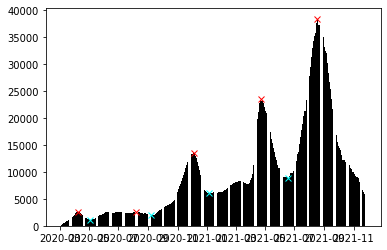

In [6]:
from scipy.signal import find_peaks
dtf_neg = dtf * -1
peaks, _ = find_peaks(dtf['SMA'].to_numpy(), distance=100, width=15)
print(peaks)
valleys, _ = find_peaks(dtf_neg['SMA'].to_numpy(), distance=30, width=20)
print(valleys)
plt.bar(dtf['SMA'].index, dtf['SMA'].to_numpy(), color="black")
plt.plot(dtf['SMA'].iloc[peaks].index, dtf['SMA'].iloc[peaks].to_numpy(), "x", color="red")
plt.plot(dtf['SMA'].iloc[valleys].index, dtf['SMA'].iloc[valleys].to_numpy(), "x", color="cyan")
plt.show()

# 1st Surge

61


<BarContainer object of 61 artists>

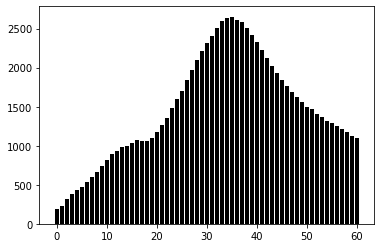

In [7]:
dtf['SMA'] = dtf['SMA'].astype(int)

counts1 = dtf['SMA'].iloc[:valleys[0]].to_numpy().tolist()
num_days = len(counts1)
print(num_days)
surge1 = np.repeat(np.arange(len(counts1)), counts1)
xk = np.arange(num_days)
plt.bar(xk, counts1, color="black")

n = 61
[61.          0.5594283   0.26523495]


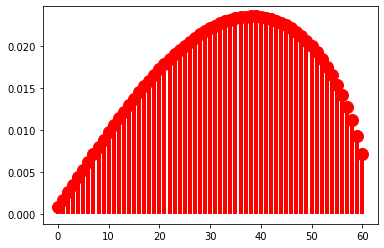

In [10]:
import numpy as np
from scipy import special
from scipy.special import entr, logsumexp, betaln, gammaln as gamln
from scipy.optimize import brute, differential_evolution
import matplotlib.pyplot as plt
import warnings
from scipy.stats import rv_discrete
import math

class polya_gen(rv_discrete):
    "Polya + c distribution"
    def _argcheck(self, n, p, gamma):
        return (p >= 0) & (p <= 1) & (gamma >= 0)
    
    def _logpmf(self, x, n, p, gamma):
        k = np.floor(x)
        combiln1 = gamln(p/gamma + k - 1 + 1) - gamln(k + 1) - gamln(p/gamma - 1 + 1)
        combiln2 = gamln((1-p)/gamma + n - k - 1 + 1) - gamln(n - k + 1) - gamln((1-p)/gamma - 1 + 1)
        combiln3 = gamln(1/gamma + n - 1 + 1) - gamln(n + 1) - gamln(1/gamma - 1 + 1)
        return combiln1 + combiln2 - combiln3
    
    def _pmf(self, x, n, p, gamma):
        return np.exp(self._logpmf(x, n, p, gamma))


def loss(free_params, *args):
    dist, x = args
    # negative log-likelihood function
    ll = -np.log(dist.pmf(x, *free_params)).sum()
    if np.isnan(ll):  # occurs when x is outside of support
        ll = np.inf   # we don't want that
    return ll

def fit_discrete(dist, x, bounds, optimizer=brute):
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore")  
        return optimizer(loss, bounds, args=(dist, x), workers=8)

polya = polya_gen(name="polya")
bounds = [(num_days, num_days), (0, 1), (0, 10)]
res = fit_discrete(polya, surge1, bounds, optimizer=differential_evolution)
print('n = '+str(num_days))
print(res.x)

xk = np.arange(num_days)
#plt.bar(xk, counts1, color="black")
fig, ax = plt.subplots(1, 1)
ax.plot(xk, polya.pmf(xk, *res.x), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, polya.pmf(xk, *res.x), colors='r', lw=4)
plt.show()

In [ ]:
class polya_gen_abc(rv_discrete):
    "Polya + c distribution"
    def _argcheck(self, n, a, b, c):
        return (a >= 1) & (b >= 1) & (c >= 1)
    
    def _logpmf(self, x, n, a, b, c):
        k = np.floor(x)
        combiln1 = gamln(a/c + k - 1 + 1) - gamln(k + 1) - gamln(a/c - 1 + 1)
        combiln2 = gamln(b/c + n - k - 1 + 1) - gamln(n - k + 1) - gamln(b/c - 1 + 1)
        combiln3 = gamln((a+b)/c + n - 1 + 1) - gamln(n + 1) - gamln((a+b)/c - 1 + 1)
        return combiln1 + combiln2 - combiln3
    
    def _pmf(self, x, n, a, b, c):
        return np.exp(self._logpmf(x, n, a, b, c))


def func(free_params, *args):
    dist, x = args
    # negative log-likelihood function
    ll = -np.log(dist.pmf(x, *free_params)).sum()
    if np.isnan(ll):  # occurs when x is outside of support
        ll = np.inf   # we don't want that
    return ll

def fit_discrete(dist, x, bounds, optimizer=brute):
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore")  
        return optimizer(func, bounds, args=(dist, x))

polya_abc = polya_gen_abc(name="polya")
bounds_abc = [(num_days, num_days), (0, 5000), (0, 5000), (1,50)]
res = fit_discrete(polya_abc, surge1, bounds_abc, optimizer=differential_evolution)
print('n = '+str(num_days))
print(res.x)

n = 61
[88.56715461 84.11608952 57.97724038]


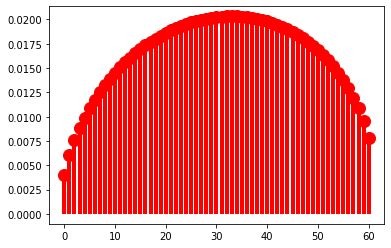

In [ ]:
xk = np.arange(num_days)
#plt.bar(xk, counts1, color="black")
fig, ax = plt.subplots(1, 1)
ax.plot(xk, polya.pmf(xk, *res.x), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, polya.pmf(xk, *res.x), colors='r', lw=4)
plt.show()

# 2nd Surge

125


<BarContainer object of 125 artists>

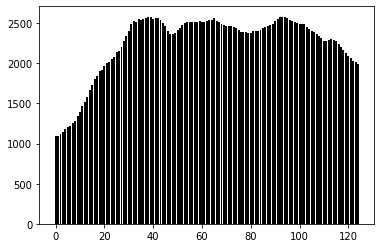

In [11]:
counts2 = dtf['SMA'].iloc[valleys[0]:valleys[1]].to_numpy().tolist()
num_days = len(counts2)
print(num_days)
xk = np.arange(num_days)
surge2 = np.repeat(np.arange(len(counts2)), counts2)
plt.bar(xk, counts2, color="black")

n = 125
[125.           0.52686935   0.40126907]


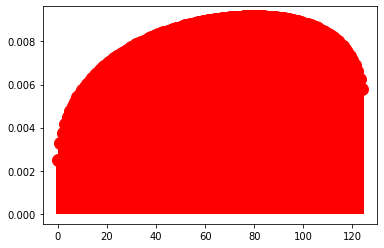

In [12]:
bounds = [(num_days, num_days), (0, 1), (0, 10)]
res = fit_discrete(polya, surge2, bounds, optimizer=differential_evolution)
print('n = '+str(num_days))
print(res.x)

xk = np.arange(num_days)
#plt.bar(xk, counts1, color="black")
fig, ax = plt.subplots(1, 1)
ax.plot(xk, polya.pmf(xk, *res.x), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, polya.pmf(xk, *res.x), colors='r', lw=4)
plt.show()

# 3rd Surge

121


<BarContainer object of 121 artists>

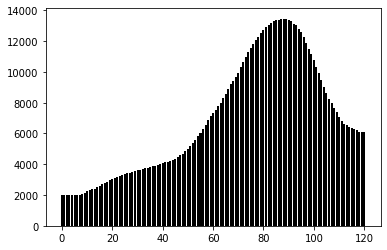

In [13]:
counts3 = dtf['SMA'].iloc[valleys[1]:valleys[2]].to_numpy().tolist()
num_days = len(counts3)
print(num_days)
xk = np.arange(num_days)
surge3 = np.repeat(np.arange(len(counts3)), counts3)
plt.bar(xk, counts3, color="black")

n = 121
[121.           0.60396697   0.30474821]


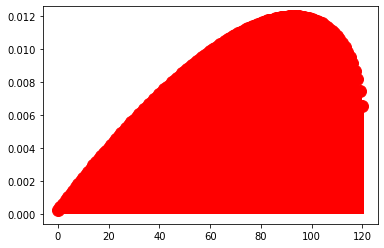

In [14]:
bounds = [(num_days, num_days), (0, 1), (0, 10)]
res = fit_discrete(polya, surge3, bounds, optimizer=differential_evolution)
print('n = '+str(num_days))
print(res.x)

xk = np.arange(num_days)
#plt.bar(xk, counts1, color="black")
fig, ax = plt.subplots(1, 1)
ax.plot(xk, polya.pmf(xk, *res.x), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, polya.pmf(xk, *res.x), colors='r', lw=4)
plt.show()

# 4th Surge

165


<BarContainer object of 165 artists>

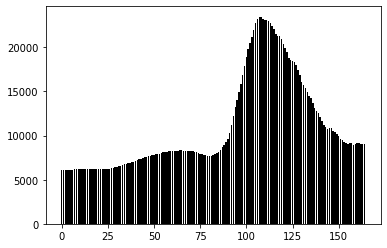

In [15]:
counts4 = dtf['SMA'].iloc[valleys[2]:valleys[3]].to_numpy().tolist()
num_days = len(counts4)
print(num_days)
xk = np.arange(num_days)
surge4 = np.repeat(np.arange(len(counts4)), counts4)
plt.bar(xk, counts4, color="black")

n = 165
[165.           0.55731599   0.36390371]


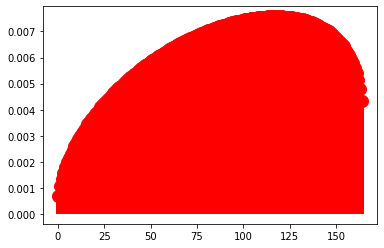

In [16]:
bounds = [(num_days, num_days), (0, 1), (0, 10)]
res = fit_discrete(polya, surge4, bounds, optimizer=differential_evolution)
print('n = '+str(num_days))
print(res.x)

xk = np.arange(num_days)
#plt.bar(xk, counts1, color="black")
fig, ax = plt.subplots(1, 1)
ax.plot(xk, polya.pmf(xk, *res.x), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, polya.pmf(xk, *res.x), colors='r', lw=4)
plt.show()

# 5th Surge

160


<BarContainer object of 160 artists>

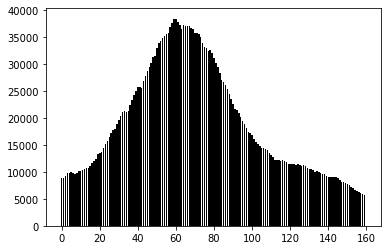

In [17]:
counts5 = dtf['SMA'].iloc[valleys[3]:].to_numpy().tolist()
num_days = len(counts5)
print(num_days)
xk = np.arange(num_days)
surge5 = np.repeat(np.arange(len(counts5)), counts5)
plt.bar(xk, counts5, color="black")

n = 160
[160.           0.44622485   0.2516148 ]


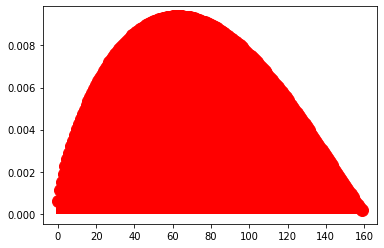

In [18]:
bounds = [(num_days, num_days), (0, 1), (0, 10)]
res = fit_discrete(polya, surge5, bounds, optimizer=differential_evolution)
print('n = '+str(num_days))
print(res.x)

xk = np.arange(num_days)
#plt.bar(xk, counts1, color="black")
fig, ax = plt.subplots(1, 1)
ax.plot(xk, polya.pmf(xk, *res.x), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, polya.pmf(xk, *res.x), colors='r', lw=4)
plt.show()